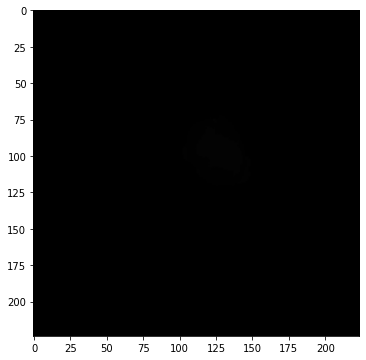

In [1]:
# Let's take a look at the dataset
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('data/BRATS2013/labels/BraTS19_2013_0_1_61.png')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [3]:
import os.path as osp
import numpy as np
from PIL import Image
# convert dataset annotation to semantic segmentation map
data_root = 'data/BRATS2013'
img_dir = 'images'
ann_dir = 'labels'
# define class and plaette for better visualization
classes = ('bg', 'WT', 'TC', 'ET')
palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34]]

In [4]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open('data/brats/annotations/training/BraTS19_2013_0_1_37.png')#.astype(uint8)
img = np.array(img).astype(np.uint8)
img =  Image.fromarray(img).convert('P')
img.putpalette(np.array(palette, dtype=np.uint8))
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(4)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data/brats/annotations/training/BraTS19_2013_0_1_37.png'

In [4]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

In [5]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class Brats2013Datasets(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None


In [6]:
from mmcv import Config
# cfg = Config.fromfile('configs/unet/deeplabv3_unet_s5-d16_256x256_40k_hrf.py')
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py')

In [7]:
from mmseg.apis import set_random_seed

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 4
cfg.model.auxiliary_head.num_classes = 4

# Modify dataset type and path
cfg.dataset_type = 'Brats2013Datasets'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu= 4

#cfg.img_norm_cfg = dict(
#    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(224, 224), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(224, 224),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 200
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=4,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_index=2,
        channels=256,
        num_convs=1,
        concat_input=F

In [8]:
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor
from mmseg.datasets import build_dataset
from mmseg.apis import set_random_seed
from mmcv import Config

In [9]:
def main():
    cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py')
    # Since we use only one GPU, BN is used instead of SyncBN
    cfg.norm_cfg = dict(type='BN', requires_grad=True)
    cfg.model.backbone.norm_cfg = cfg.norm_cfg
    cfg.model.decode_head.norm_cfg = cfg.norm_cfg
    cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
    # modify num classes of the model in decode/auxiliary head
    cfg.model.decode_head.num_classes = 4
    cfg.model.auxiliary_head.num_classes = 4

    # Modify dataset type and path
    cfg.dataset_type = 'Brats2013Datasets'
    cfg.data_root = data_root

    cfg.data.samples_per_gpu = 8
    cfg.data.workers_per_gpu= 2
    cfg.persistent_workers=True

    #cfg.img_norm_cfg = dict(
    #    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
    cfg.crop_size = (256, 256)
    cfg.train_pipeline = [
        dict(type='LoadImageFromFile'),
        dict(type='LoadAnnotations'),
        dict(type='Resize', img_scale=(224, 224), ratio_range=(0.5, 2.0)),
        dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
        dict(type='RandomFlip', flip_ratio=0.5),
        dict(type='PhotoMetricDistortion'),
        dict(type='Normalize', **cfg.img_norm_cfg),
        dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
        dict(type='DefaultFormatBundle'),
        dict(type='Collect', keys=['img', 'gt_semantic_seg']),
    ]

    cfg.test_pipeline = [
        dict(type='LoadImageFromFile'),
        dict(
            type='MultiScaleFlipAug',
            img_scale=(224, 224),
            # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
            flip=False,
            transforms=[
                dict(type='Resize', keep_ratio=True),
                dict(type='RandomFlip'),
                dict(type='Normalize', **cfg.img_norm_cfg),
                dict(type='ImageToTensor', keys=['img']),
                dict(type='Collect', keys=['img']),
            ])
    ]


    cfg.data.train.type = cfg.dataset_type
    cfg.data.train.data_root = cfg.data_root
    cfg.data.train.img_dir = img_dir
    cfg.data.train.ann_dir = ann_dir
    cfg.data.train.pipeline = cfg.train_pipeline
    cfg.data.train.split = 'splits/train.txt'

    cfg.data.val.type = cfg.dataset_type
    cfg.data.val.data_root = cfg.data_root
    cfg.data.val.img_dir = img_dir
    cfg.data.val.ann_dir = ann_dir
    cfg.data.val.pipeline = cfg.test_pipeline
    cfg.data.val.split = 'splits/val.txt'

    cfg.data.test.type = cfg.dataset_type
    cfg.data.test.data_root = cfg.data_root
    cfg.data.test.img_dir = img_dir
    cfg.data.test.ann_dir = ann_dir
    cfg.data.test.pipeline = cfg.test_pipeline
    cfg.data.test.split = 'splits/val.txt'

    # We can still use the pre-trained Mask RCNN model though we do not need to
    # use the mask branch
    cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'
    
    # Set up working dir to save files and logs.
    cfg.work_dir = './work_dirs/tutorial'

    cfg.runner.max_iters = 200
    cfg.log_config.interval = 10
    cfg.evaluation.interval = 200
    cfg.checkpoint_config.interval = 200

    # Set seed to facitate reproducing the result
    cfg.seed = 0
    set_random_seed(0, deterministic=False)
    cfg.gpu_ids = range(1)

    # Let's have a look at the final config used for training
    print(f'Config:\n{cfg.pretty_text}')
    
    # Build the dataset
    datasets = [build_dataset(cfg.data.train)]

    # Build the detector
    model = build_segmentor(
        cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
    # Add an attribute for visualization convenience
    model.CLASSES = datasets[0].CLASSES
    # Create work_dir
    mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
    train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

In [10]:
if __name__ == '__main__':
    main()

2022-05-02 09:49:18,987 - mmseg - INFO - Loaded 384 images


Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=4,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_index=2,
        channels=256,
        num_convs=1,
        concat_input=F

D:\Program\PyCharm\mmsegment\mmsegmentation\mmsegmentation\mmseg\models\backbones\resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
D:\Program\PyCharm\mmsegment\mmsegmentation\mmsegmentation\mmseg\models\losses\cross_entropy_loss.py:233: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '
2022-05-02 09:49:20,768 - mmseg - INFO - Loaded 96 images
2022-05-02 09:49:20,769 - mmseg - INFO - load checkpoint from local path: checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
2022-05-02 09:49:20,978 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight:

BrokenPipeError: [Errno 32] Broken pipe

In [ ]:
img = mmcv.imread('iccv09Data/images/6000124.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

2022-05-02 16:04:16,474 - mmseg - INFO - Loaded 405 images


Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='UNet',
        in_channels=3,
        base_channels=64,
        num_stages=5,
        strides=(1, 1, 1, 1, 1),
        enc_num_convs=(2, 2, 2, 2, 2),
        dec_num_convs=(2, 2, 2, 2),
        downsamples=(True, True, True, True),
        enc_dilations=(1, 1, 1, 1, 1),
        dec_dilations=(1, 1, 1, 1),
        with_cp=False,
        conv_cfg=None,
        norm_cfg=dict(type='BN', requires_grad=True),
        act_cfg=dict(type='ReLU'),
        upsample_cfg=dict(type='InterpConv'),
        norm_eval=False),
    decode_head=dict(
        type='FCNHead',
        in_channels=64,
        in_index=4,
        channels=64,
        num_convs=1,
        concat_input=False,
        dropout_ratio=0.1,
        num_classes=4,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=[
            dict(
   

D:\Program\PyCharm\mmsegment\mmsegmentation\mmsegmentation\mmseg\models\losses\cross_entropy_loss.py:233: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '
2022-05-02 16:04:16,866 - mmseg - INFO - Loaded 75 images
2022-05-02 16:04:16,868 - mmseg - INFO - load checkpoint from local path: work_dirs/tutorial/iter_1000.pth
2022-05-02 16:04:16,995 - mmseg - INFO - Start running, host: Wuyfee@DESKTOP-O5IVC3V, work_dir: D:\Program\PyCharm\mmsegment\mmsegmentation\mmsegmentation\work_dirs\tutorial
2022-05-02 16:04:16,995 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) Tex

<Figure size 576x432 with 0 Axes>

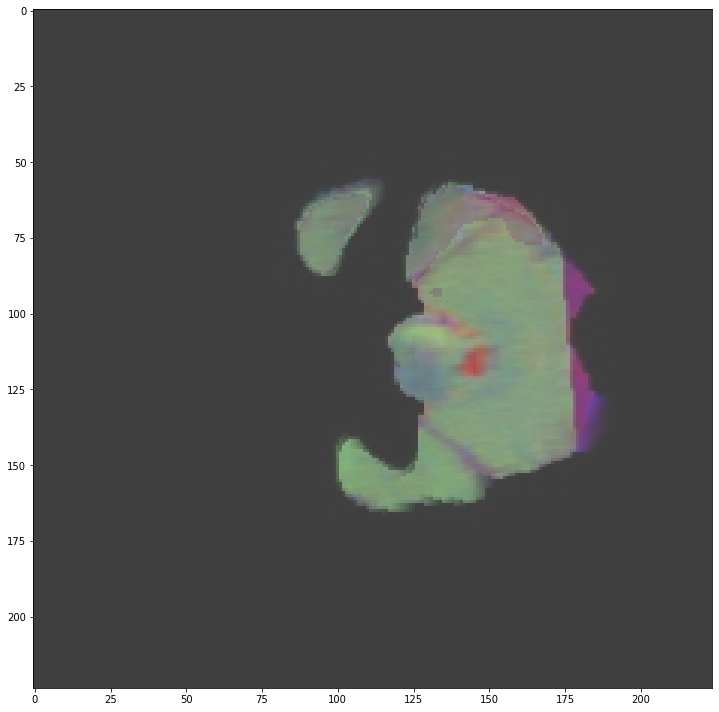

In [1]:
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor, inference_segmentor, show_result_pyplot
from mmseg.datasets import build_dataset
from mmseg.apis import set_random_seed
import mmcv
from mmcv import Config
import os.path as osp
import matplotlib.pyplot as plt
classes = ('BG', 'WT', 'TC', 'ET')
palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34]]
def main():

    # cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py')
    cfg = Config.fromfile('configs/unet/fcn_unet_s5-d16_ce-1.0-dice-3.0_256x256_40k_brats.py')
    # We can still use the pre-trained Mask RCNN model though we do not need to
    # use the mask branch
    # cfg.load_from = 'checkpoints/fcn_unet_s5-d16_ce-1.0-dice-3.0_256x256_40k_hrf_20211210_201821-c314da8a.pth'
    cfg.load_from = 'work_dirs/tutorial/iter_1000.pth'

    # Set up working dir to save files and logs.
    cfg.work_dir = './work_dirs/tutorial'

    cfg.runner.max_iters = 10
    cfg.log_config.interval = 10
    cfg.evaluation.interval = 200
    cfg.checkpoint_config.interval = 200

    # Set seed to facitate reproducing the result
    cfg.seed = 0
    set_random_seed(0, deterministic=False)
    cfg.gpu_ids = range(1)

    # Let's have a look at the final config used for training
    print(f'Config:\n{cfg.pretty_text}')

    # Build the dataset
    datasets = [build_dataset(cfg.data.train)]

    # Build the detector

    model = build_segmentor(
        cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

    # Add an attribute for visualization convenience
    model.CLASSES = datasets[0].CLASSES
    
    # Create work_dir
    mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
    train_segmentor(model, datasets, cfg, distributed=False, validate=True,
                    meta=dict())
    
    img = mmcv.imread('data/brats/images/validation/BraTS19_2013_0_1_37.jpg')

    model.cfg = cfg
    result = inference_segmentor(model, img)
    plt.figure(figsize=(8, 6))
    show_result_pyplot(model, img, result, palette)


if __name__ == '__main__':
    main()


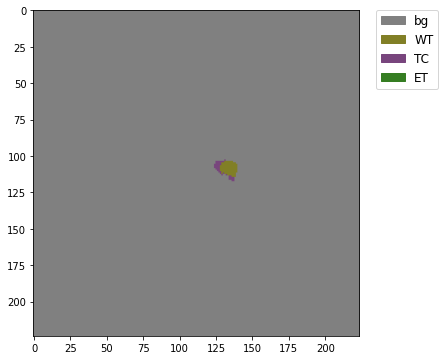

In [7]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open('D:/Program/PyCharm/mmsegment/mmsegmentation/mmsegmentation/data/brats/annotations/validation/BraTS19_2013_0_1_37.png')#.astype(uint8)
img = np.array(img).astype(np.uint8)
img =  Image.fromarray(img).convert('P')
img.putpalette(np.array(palette, dtype=np.uint8))
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(4)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()